## Supplementary files showing shapshots of SIC, SSS, and SST for ice bridge 2015-2020

In [1]:
## import required packages
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean
from pyproj import Proj, Transformer
import glob
import os
import string
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

In [2]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:45187")
client

<Client: 'tcp://127.0.0.1:45187' processes=8 threads=32, memory=123.95 GiB>

### Make plots for supplement that show ice bridge, and one week before and after, as well as one month before for multiple years

Access files and identify dates to plot

In [4]:
def generate_surrounding_dates(dates):
    """
    Given a list of dates in 'YYYYMMDD' format, return a dictionary mapping each date
    to a list of dates [4 weeks before, 1 week before, the date itself, 1 week after].
    """
    result = {}
    for date_str in dates:
        base_date = datetime.strptime(date_str, '%Y%m%d')
        date_list = [
            (base_date - timedelta(weeks=4)).strftime('%Y%m%d'),
            (base_date - timedelta(weeks=1)).strftime('%Y%m%d'),
            date_str,
            (base_date + timedelta(weeks=1)).strftime('%Y%m%d')
        ]
        result[date_str] = date_list
    return result

In [5]:
def convert_to_doy_strings(dates):
    """
    Convert a list of date strings (YYYYMMDD) to 'YYYY_DDD' format where DDD is day of year.
    """
    doy_strings = []
    for date_str in dates:
        dt = datetime.strptime(date_str, '%Y%m%d')
        doy = dt.timetuple().tm_yday
        doy_strings.append(f"{dt.year}_{doy:03d}")
    return doy_strings

#### Create custom colormap for sea ice

In [8]:
def remap_colormap(cmap, nonlin_scale=np.sqrt, n=256):
    """
    Remap a colormap so that lower values are compressed (darker colors take up less space),
    and higher values (lighter colors) are stretched out.
    
    Parameters:
    - cmap: The original colormap (e.g., cmocean.cm.ice)
    - nonlin_scale: A function that maps [0,1] -> [0,1] nonlinearly (default: np.sqrt)
    - n: Number of color levels
    
    Returns:
    - A new colormap with redistributed colors.
    """
    # Generate linearly spaced values, then apply non-linear scaling
    orig_vals = np.linspace(0, 1, n)
    remapped_vals = nonlin_scale(orig_vals)

    # Normalize remapped values to stay in [0,1]
    remapped_vals = (remapped_vals - remapped_vals.min()) / (remapped_vals.max() - remapped_vals.min())

    # Map those values through the original colormap
    new_colors = cmap(remapped_vals)
    
    return LinearSegmentedColormap.from_list(f'remapped_{cmap.name}', new_colors, N=n)

In [9]:
from matplotlib.colors import LinearSegmentedColormap

# create a nonlinearly adjusted colormap from the cmocean ice colormap
custom_ice_cmap = remap_colormap(cmocean.cm.ice, nonlin_scale=np.sqrt)  # sqrt compresses low end

## Plot

In [11]:
def plot_satellite_snapshots(sic_file_paths, sss_file_paths, sst_file_paths, save_folder):
    plt.rcParams['font.size'] = 14

    # Define projection and transformer
    nsidc_proj = Proj(proj='stere', lat_0=90, lon_0=-45, lat_ts=70, a=6378273, b=6356889.449, units='m')
    transformer = Transformer.from_proj(nsidc_proj, "epsg:4326", always_xy=True)

    fig, axes = plt.subplots(4, 2, figsize=(7.5, 13),
                             subplot_kw={'projection': ccrs.NorthPolarStereo(central_longitude=-155)})
    plt.subplots_adjust(wspace=0.1, hspace=0.2, right=0.9, top=0.93)
    axes = axes.reshape(4, 2)

    labels = list(string.ascii_lowercase)
    row_titles = ["Four Weeks Before Ice Bridge", "One Week Before Ice Bridge", "Ice Bridge", "One Week After Ice Bridge"]

    for i in range(len(sic_file_paths)):
        # Load SIC
        sic_ds = xr.open_dataset(sic_file_paths[i])
        sic = sic_ds['cdr_seaice_conc'].squeeze()
        if sic.max() > 1.5:
            sic = sic / 100.0
        sic_masked = np.where(sic > 0.15, sic, np.nan)

        # Load SST and SSS
        sss = xr.open_dataset(sss_file_paths[i])['sss_smap'].squeeze()
        sst_ds = xr.open_dataset(sst_file_paths[i])
        sst = sst_ds['sst'].squeeze()
        sst_ice = sst_ds['ice'].squeeze()

        # Get grid and transform
        x = sic_ds['x'].values
        y = sic_ds['y'].values
        X, Y = np.meshgrid(x, y)
        lon, lat = transformer.transform(X, Y)

        # Title date
        dt = pd.to_datetime(sic_ds['time'].values)
        date_str = dt.strftime('%b %d, %Y')
        row_title = f"{row_titles[i]} ({date_str[0]})"

        row_top_y = max(axes[i, 0].get_position().y1, axes[i, 1].get_position().y1)
        fig.text(0.5, row_top_y + 0.008, row_title, ha='center', fontsize=15)

        for j in range(2):
            ax = axes[i, j]
            ax.set_extent([-161, -126, 69, 78], crs=ccrs.PlateCarree())
            ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', facecolor='lightgray'))
            ax.add_feature(cfeature.BORDERS.with_scale('10m'))
            ax.add_feature(cfeature.COASTLINE.with_scale('10m'))
            gl = ax.gridlines(draw_labels=False, linewidth=0.5, color='gray', alpha=0.5,
                              linestyle='--', ylocs=[67, 69, 71, 73, 75, 77, 79])

            if j == 0:
                sss_cb = sss.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmocean.cm.haline,
                                  vmin=22, vmax=31, add_colorbar=False, extend='both')
            else:
                sst_cb = sst.where(sst_ice.isnull()).plot(ax=ax, transform=ccrs.PlateCarree(),
                                                          cmap=cmocean.cm.thermal, vmin=-2, vmax=4.5,
                                                          add_colorbar=False, extend='both')

            sic_cb = ax.pcolormesh(lon, lat, sic_masked * 100, transform=ccrs.PlateCarree(),
                                   cmap=custom_ice_cmap, shading='auto', vmin=0, vmax=100)

            ax.set_title("")

            regional_mask = ((lon >= -165) & (lon <= -120) & (lat >= 66) & (lat <= 80))
            sic_region = np.where(regional_mask, sic, np.nan)
            ax.contour(lon, lat, sic_region * 100, levels=[15], colors='magenta',
                       linewidths=1, transform=ccrs.PlateCarree())

            ax.text(0.03, 0.96, f'({labels[i * 2 + j]})', transform=ax.transAxes,
                    fontsize=18, va='top', ha='left',
                    bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.2', alpha=0.8))

    # Colorbars
    cb_sss = fig.colorbar(sss_cb, cax=fig.add_axes([0.13, 0.07, 0.36, 0.015]), orientation='horizontal',
                 extend='both')
    cb_sss.set_ticks([23,25,27,29,31])
    cb_sss.set_label('SSS (psu)')
    
    fig.colorbar(sic_cb, cax=fig.add_axes([0.13, 0.0, 0.36, 0.015]), orientation='horizontal'
                ).set_label('SIC (%)')
    
    cb_sst = fig.colorbar(sst_cb, cax=fig.add_axes([0.535, 0.07, 0.36, 0.015]), orientation='horizontal',
                          extend='both')
    cb_sst.set_label('SST (°C)')

    # SIC 15% line on colorbar
    fig.axes[-2].vlines(15, *fig.axes[-2].get_xlim(), colors='magenta', linewidth=1.5)

    # Lat/lon text
    fig.text(0.12, 0.15, '71°N', fontsize=10, ha='right', va='center')
    fig.text(0.12, 0.185, '73°N', fontsize=10, ha='right', va='center')
    fig.text(0.12, 0.22, '75°N', fontsize=10, ha='right', va='center')
    fig.text(0.12, 0.254, '77°N', fontsize=10, ha='right', va='center')
    fig.text(0.144, 0.107, '160°W', fontsize=10, ha='center', va='top')
    fig.text(0.25, 0.107, '150°W', fontsize=10, ha='center', va='top')
    fig.text(0.36, 0.107, '140°W', fontsize=10, ha='center', va='top')
    fig.text(0.49, 0.107, '130°W', fontsize=10, ha='center', va='top')

    # Save the figure with year in filename
    year = pd.to_datetime(xr.open_dataset(sic_file_paths[0])['time'].values).year
    filename = f"satellite_snaps_{year[0]}.png"
    save_path = os.path.join(save_folder, filename)
    # fig.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

    return fig

## Put it all together

In [13]:
# manually specify when ice bridges were observed
ice_bridge_dates = ['20151023', '20161021', '20171030', '20180913', '20191025', '20201016', '20211020','20221022', '20231102', '20241105']

In [14]:
# select dates
surrounding_dates = generate_surrounding_dates(ice_bridge_dates)
print(surrounding_dates)

{'20151023': ['20150925', '20151016', '20151023', '20151030'], '20161021': ['20160923', '20161014', '20161021', '20161028'], '20171030': ['20171002', '20171023', '20171030', '20171106'], '20180913': ['20180816', '20180906', '20180913', '20180920'], '20191025': ['20190927', '20191018', '20191025', '20191101'], '20201016': ['20200918', '20201009', '20201016', '20201023'], '20211020': ['20210922', '20211013', '20211020', '20211027'], '20221022': ['20220924', '20221015', '20221022', '20221029'], '20231102': ['20231005', '20231026', '20231102', '20231109'], '20241105': ['20241008', '20241029', '20241105', '20241112']}


Ice Bridge Date: 20151023
All Dates: ['20150925', '20151016', '20151023', '20151030']
---


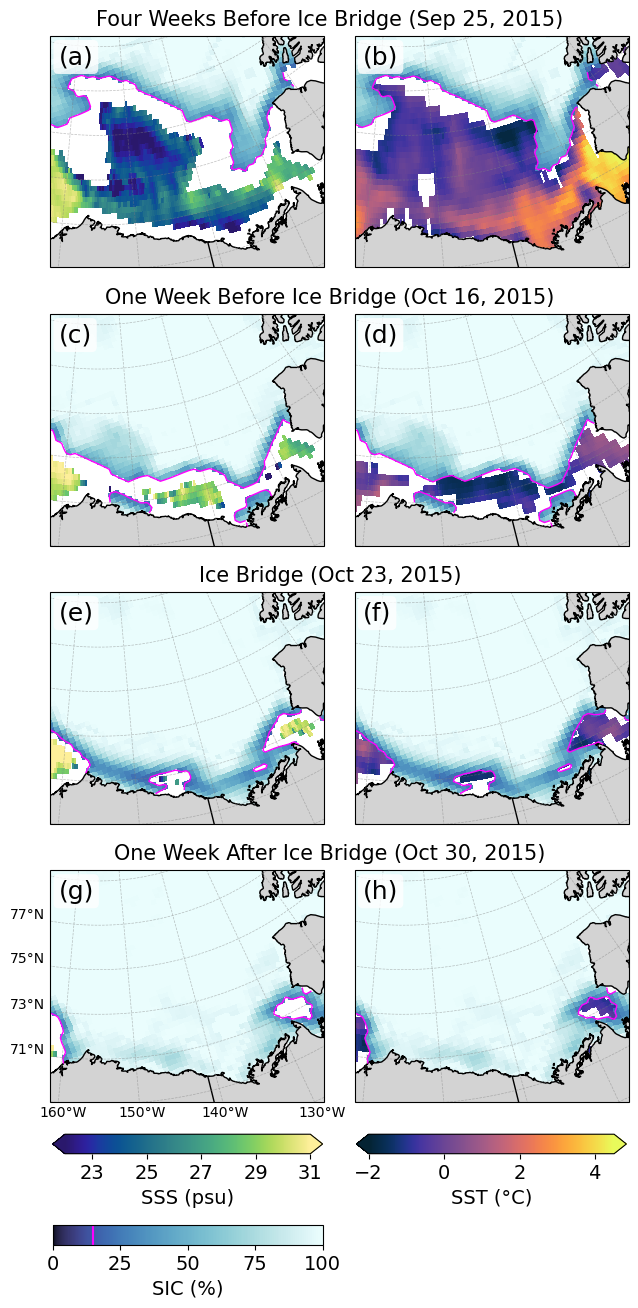

Ice Bridge Date: 20161021
All Dates: ['20160923', '20161014', '20161021', '20161028']
---


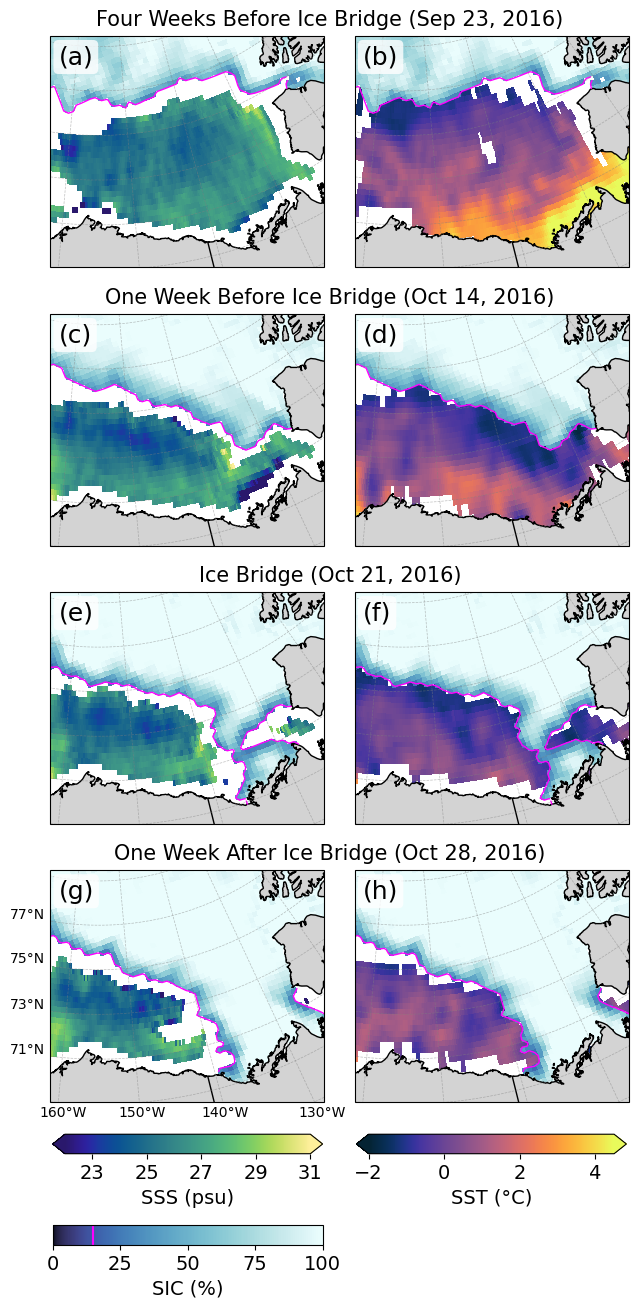

Ice Bridge Date: 20171030
All Dates: ['20171002', '20171023', '20171030', '20171106']
---


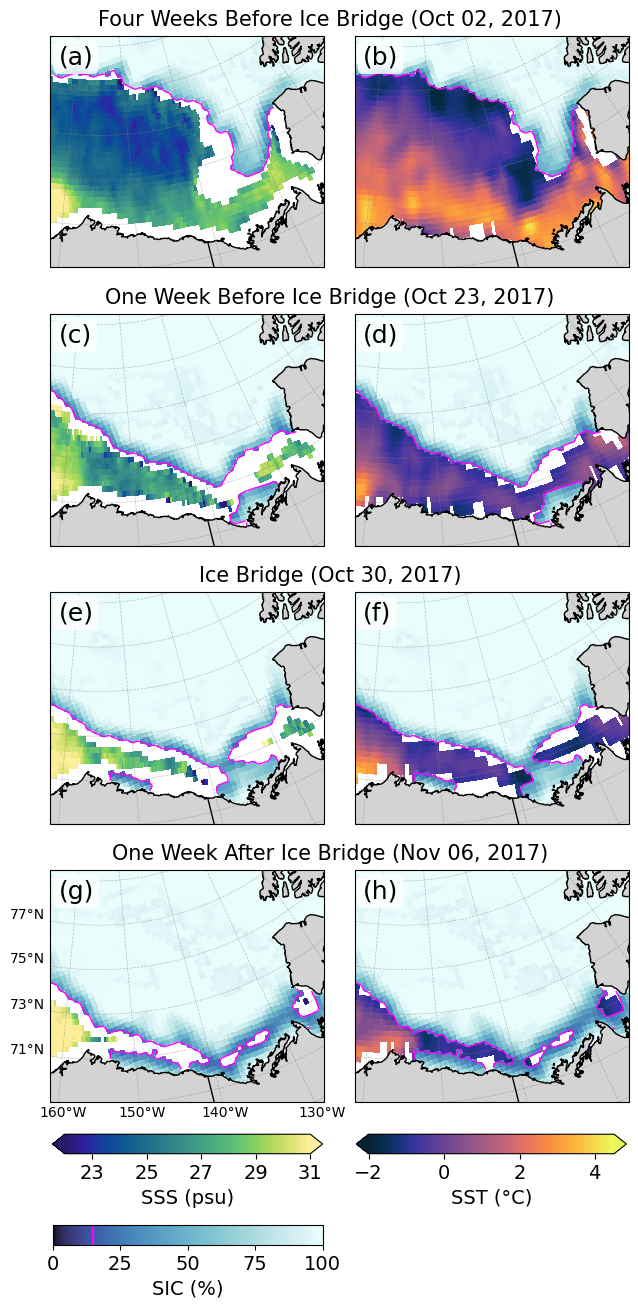

Ice Bridge Date: 20180913
All Dates: ['20180816', '20180906', '20180913', '20180920']
---


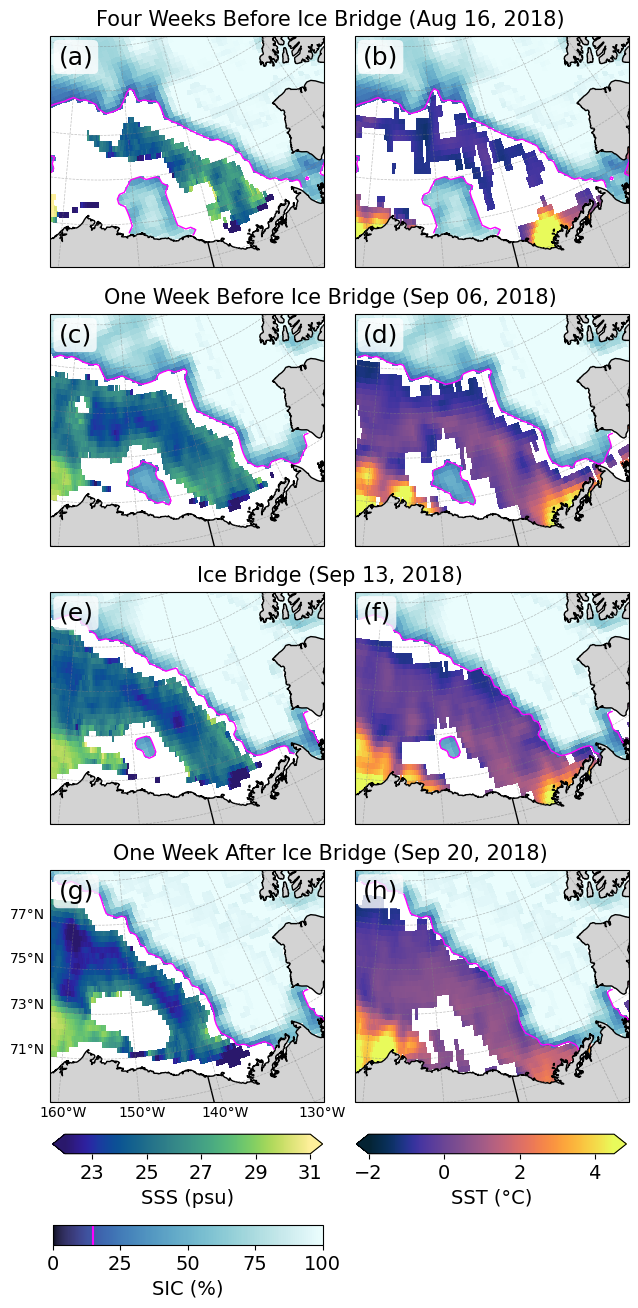

Ice Bridge Date: 20191025
All Dates: ['20190927', '20191018', '20191025', '20191101']
---


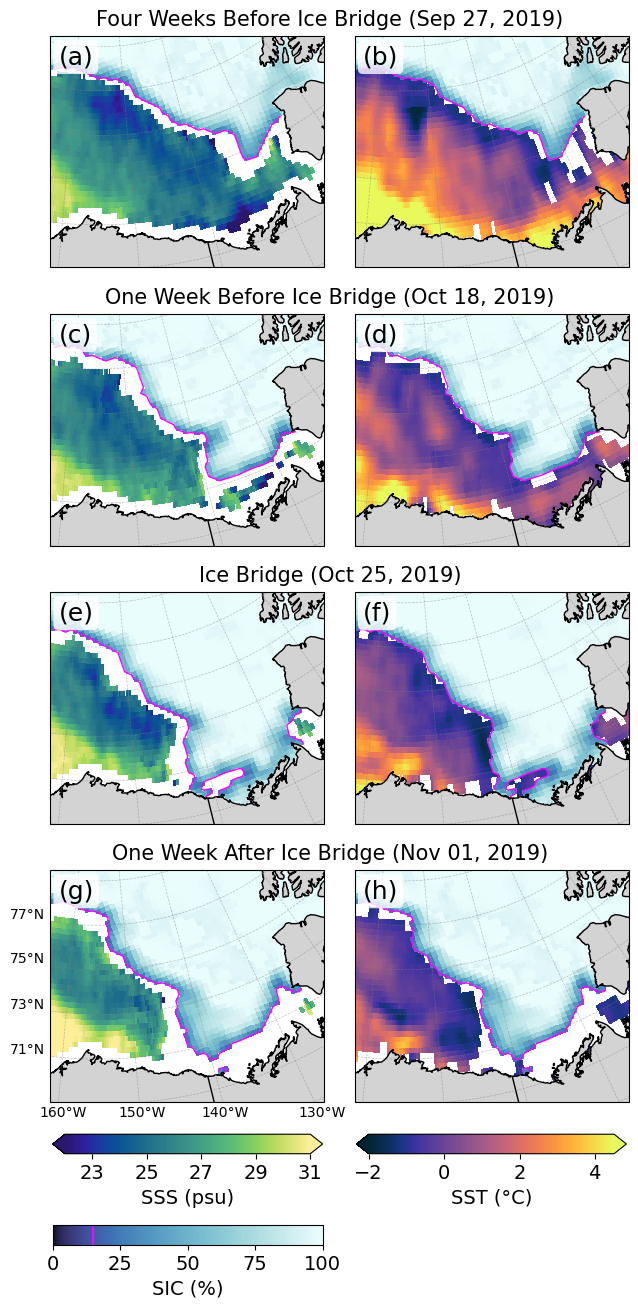

Ice Bridge Date: 20201016
All Dates: ['20200918', '20201009', '20201016', '20201023']
---


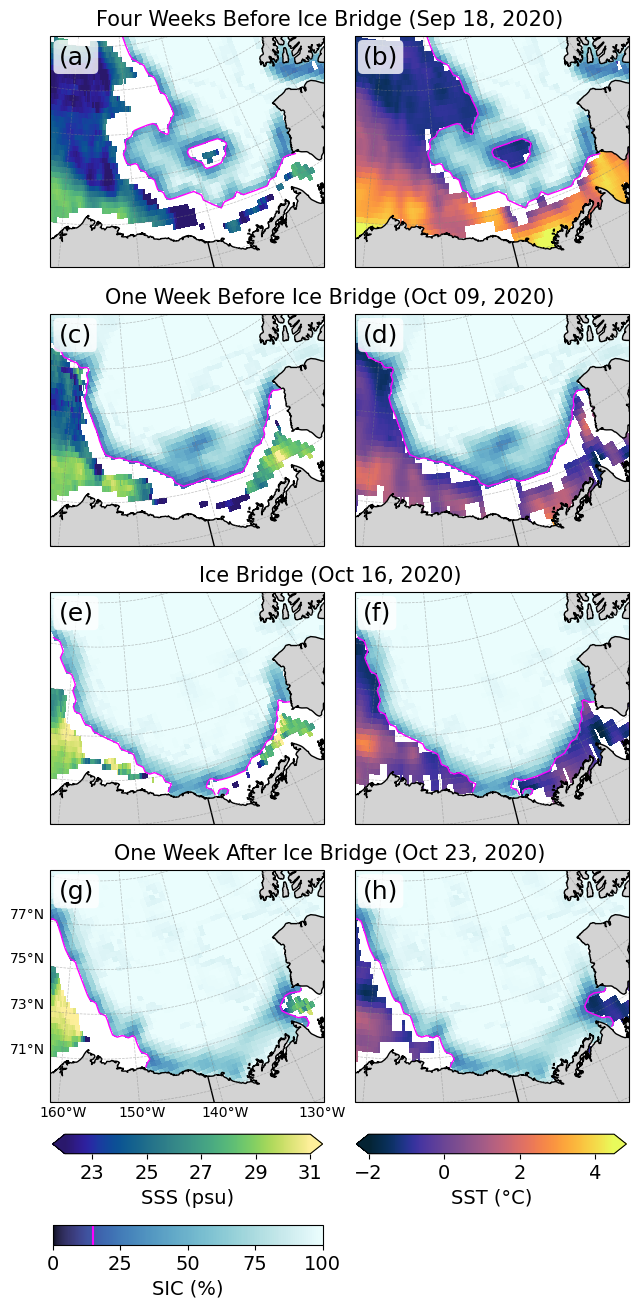

Ice Bridge Date: 20211020
All Dates: ['20210922', '20211013', '20211020', '20211027']
---


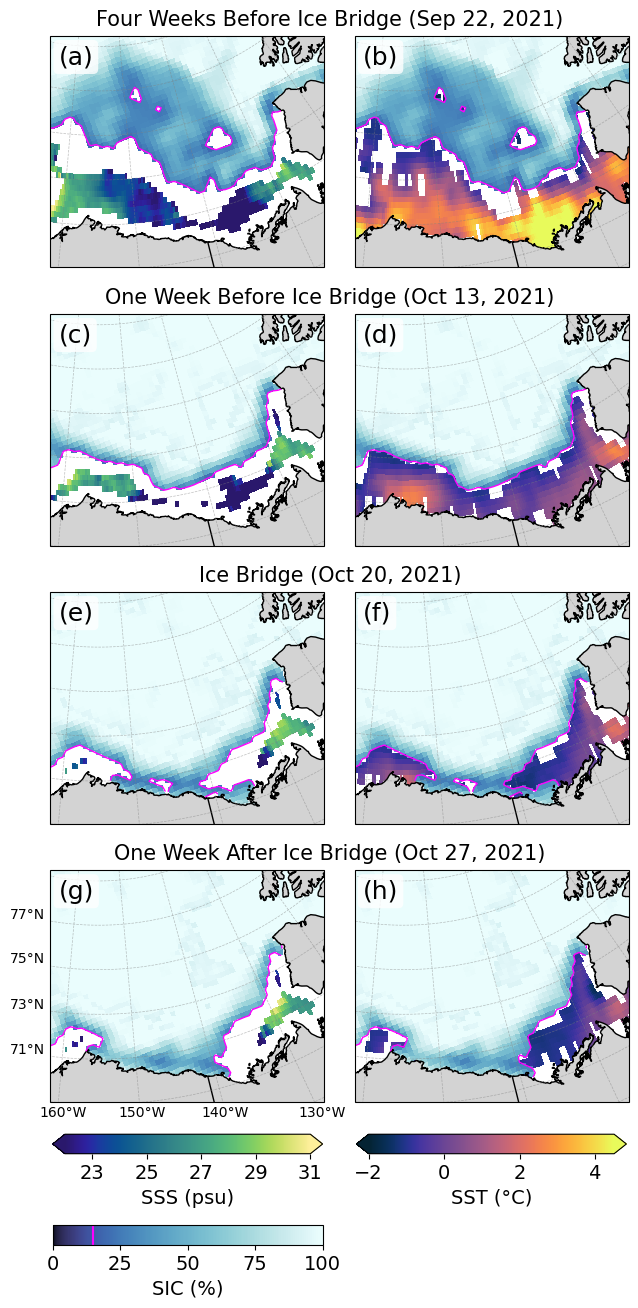

Ice Bridge Date: 20221022
All Dates: ['20220924', '20221015', '20221022', '20221029']
---


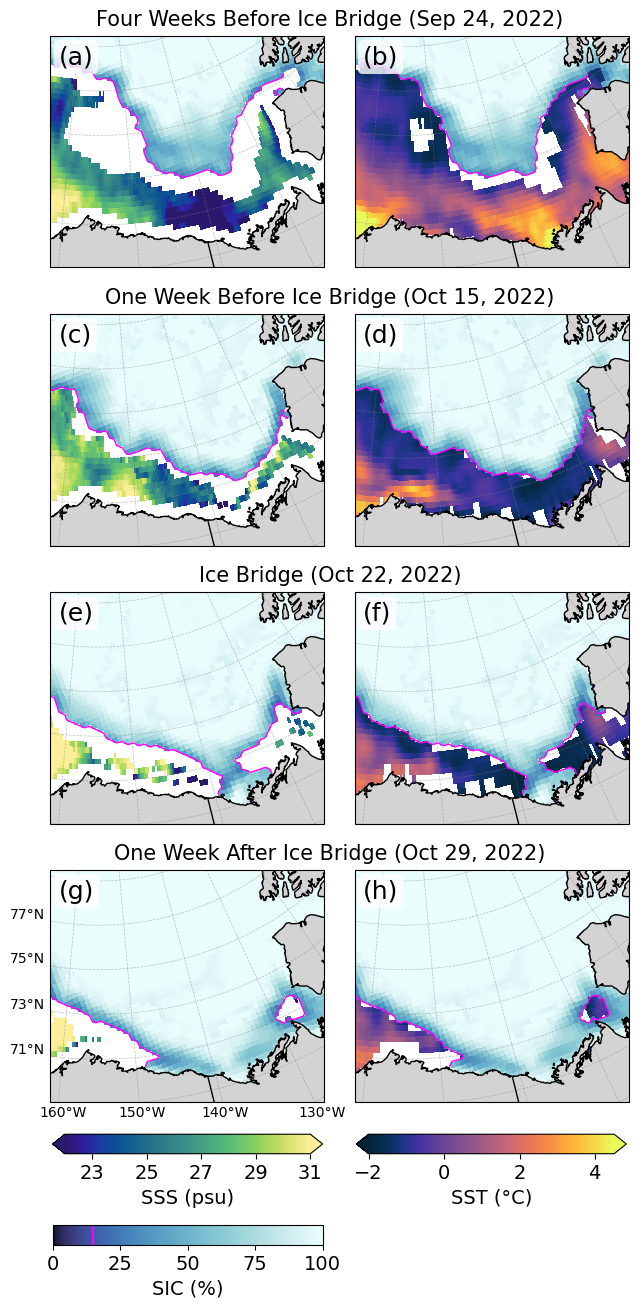

Ice Bridge Date: 20231102
All Dates: ['20231005', '20231026', '20231102', '20231109']
---


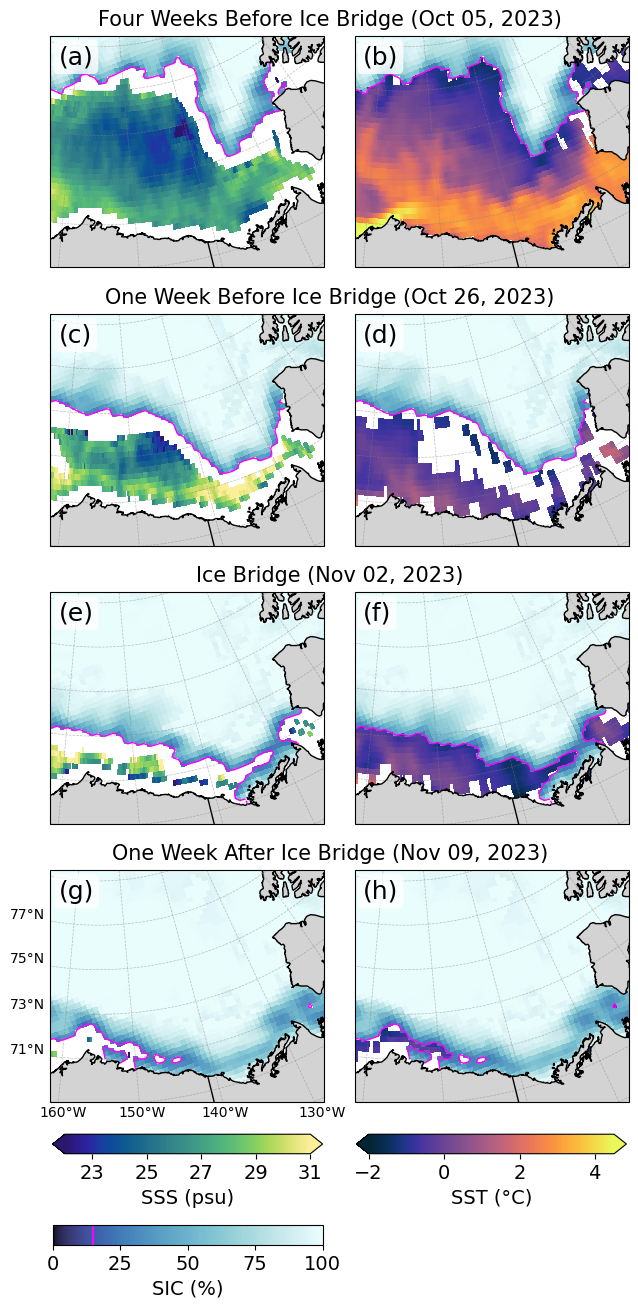

Ice Bridge Date: 20241105
All Dates: ['20241008', '20241029', '20241105', '20241112']
---


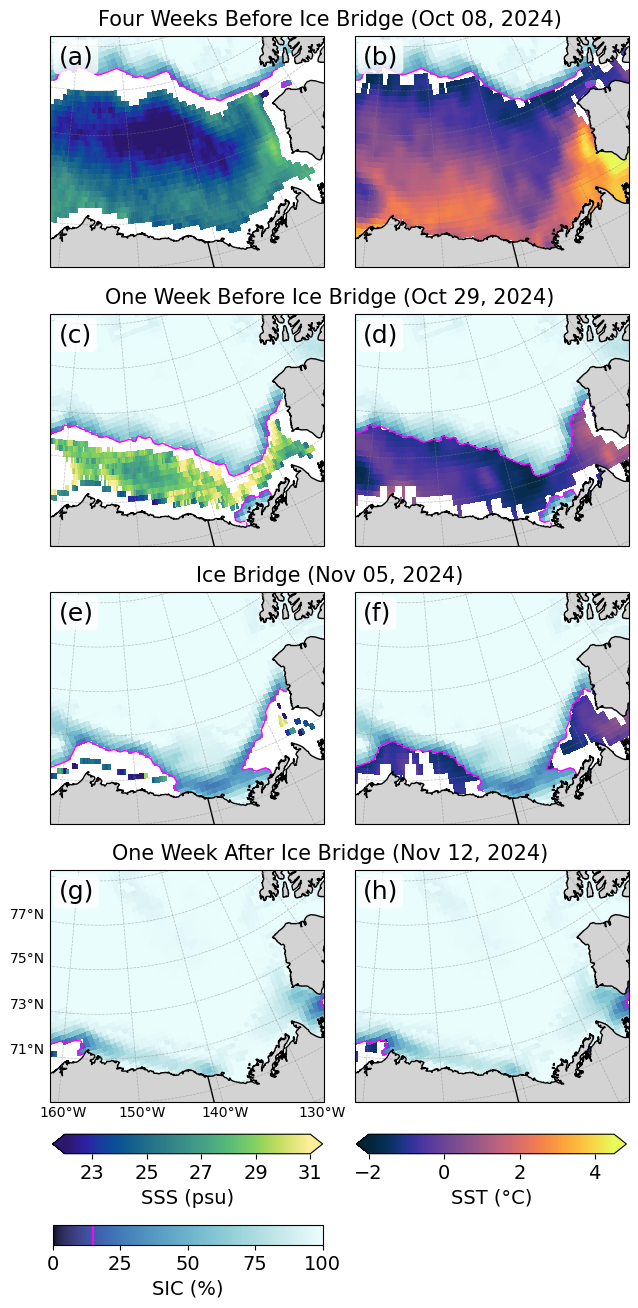

In [15]:
for ice_bridge_date, all_dates in surrounding_dates.items():

    print("Ice Bridge Date:", ice_bridge_date)
    print("All Dates:", all_dates)
    print("---")

    year = ice_bridge_date[0:4]
    
    # Set data directory and load all matching NetCDF files
    sic_dir = "/home/jpluser/efs-mount-point/mzahn/satellite_data/sic_nsidc_cdr"
    sic_file_paths_all = sorted(glob.glob(os.path.join(sic_dir, f"*{year}*.nc")))
    
    sss_dir = "/home/jpluser/efs-mount-point/mzahn/satellite_data/sss_rss_smap"
    sss_file_paths_all = sorted(glob.glob(os.path.join(sss_dir, f"*{year}*.nc")))
    
    sst_dir = "/home/jpluser/efs-mount-point/mzahn/satellite_data/sst_noaa_oisst"
    sst_file_paths_all = sorted(glob.glob(os.path.join(sst_dir, f"*{year}*.nc")))

    # select specific dates for SIC and SST
    sic_file_paths = [[item for item in sic_file_paths_all if all_dates[0] in item][0],\
                      [item for item in sic_file_paths_all if all_dates[1] in item][0],\
                      [item for item in sic_file_paths_all if all_dates[2] in item][0],\
                      [item for item in sic_file_paths_all if all_dates[3] in item][0]]

    sst_file_paths = [[item for item in sst_file_paths_all if all_dates[0] in item][0],\
                      [item for item in sst_file_paths_all if all_dates[1] in item][0],\
                      [item for item in sst_file_paths_all if all_dates[2] in item][0],\
                      [item for item in sst_file_paths_all if all_dates[3] in item][0]]

    # SSS is in DOY format so need to convert the date first
    doy_dates = convert_to_doy_strings(all_dates)
    sss_file_paths = [[item for item in sss_file_paths_all if doy_dates[0] in item][0],\
                      [item for item in sss_file_paths_all if doy_dates[1] in item][0],\
                      [item for item in sss_file_paths_all if doy_dates[2] in item][0],\
                      [item for item in sss_file_paths_all if doy_dates[3] in item][0]]

    fig = plot_satellite_snapshots(
        sic_file_paths=sic_file_paths,
        sss_file_paths=sss_file_paths,
        sst_file_paths=sst_file_paths,
        save_folder='/home/jpluser/git_repos/SASSIE_ECCO_salinity_stratification/figures'
    )